In [56]:
import os
from skimage.io import imread
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import random
from collections import Counter


import torch
import torchvision.transforms as transforms
from PIL import Image

## Color detection of ants
This project aims at deteting the color of ants in images.

![alt text](ants_color_wheel.jpg "Ants color wheel")


### Data
**Information from lab:** \
FOR PROJECT on COULOUR DETECTION
In colour_digitalization.zip --> an excel file with 28770 spécimens and the information relative to the "human being digitalization". 
Column names are mostly explicit. Last column max_distance corresponds to the maximum distance among the six distances between colours observed on head-thorax-abdomen (six couples: head-thorax; thorax-abdomen, etc). If the distance is small (<30), we could consider the specimen as homogeneous in terms of colour variation.


**original** \
This folder contains 38578 images of ants. \
In these images there is the measurement stick 

**colour_digitalization.xlsx** \
Contains data about each ant. \
Specimen is the unique identifier of each ant and this is also used as file name for each ant image. \
In this file we have the RGB values for each of the body parts of the ant head, thorax, abdomen and the x,y coordinates where these values have been taken \

**Some maybe useful links:**

https://medium.com/@rajat01221/the-mathematics-behind-color-detection-in-machine-learning-algorithms-fc79a8eddf98

https://towardsdatascience.com/color-identification-in-images-machine-learning-application-b26e770c4c71

https://link.springer.com/chapter/10.1007/978-3-031-19647-8_5





#### Reading in some ant images from original folder 

In [2]:
def read_image_file_names(folder_path):
    # List all files in the folder and sort them
    all_files = sorted(os.listdir(folder_path))

    # Filter only the image files (e.g., with extensions .jpg, .png)
    image_file_names = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    return image_file_names


In [3]:
def clean_file_name_png(file_names):
    """
    Extracting specimen name from png files
    """
    cleaned_file_names = [file.replace('_p_1.png', '') for file in file_names]

    return cleaned_file_names

def clean_file_name_jpg(file_names):
    """
    Extracting specimen name from jpg files
    """
    cleaned_file_names = [file.replace('_p_1.jpg', '') for file in file_names]

    return cleaned_file_names

def clean_file_name_mask(file_names):
    """
    Extracting specimen name from jpg files
    """
    cleaned_file_names = [file.replace('_msk', '') for file in file_names]
    cleaned_file_names = [file.replace('_p.png', '') for file in cleaned_file_names]

    return cleaned_file_names

def add_jpg(cleaned_file_names):
    file_names = [file + '_p_1.jpg' for file in cleaned_file_names]

    return file_names


In [4]:
# Path to the folder containing images
folder_path_img = '/Volumes/T7 Shield/AntProject/original'
image_file_names = read_image_file_names(folder_path_img)

folder_path_ants = '/Volumes/T7 Shield/AntProject/without_background'
ant_file_names = read_image_file_names(folder_path_ants)

folder_path_mask = '/Volumes/T7 Shield/AntProject/muticlass_model/masks_4_categories/masks_4_categories'
mask_file_names = read_image_file_names(folder_path_mask)

path_df = '/Volumes/T7 Shield/AntProject/colour_digitalization.xlsx'

In [5]:
# Read the Excel file
df = pd.read_excel(path_df, sheet_name='Sheet1', engine='openpyxl')
df.head()

/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,specimen,original_file,species,x_head,y_head,x_thorax,y_thorax,x_abdomen,y_abdomen,r_head,g_head,b_head,r_thorax,g_thorax,b_thorax,r_abdomen,g_abdomen,b_abdomen,max_distance
0,casent0280684,casent0280684_p_1.jpg,Acanthognathus brevicornis,541.761428,611.801353,710.781834,634.915325,1186.833259,449.712645,108,54,18,82,37,16,91,52,21,15.64
1,casent0914659,casent0914659_p_1.jpg,Acanthognathus brevicornis,343.088620,585.595543,569.682016,656.890638,1071.440567,336.927097,119,68,15,118,74,37,166,129,77,26.18
2,usnment00445715,usnment00445715_p_1.jpg,Acanthognathus lentus,401.710873,565.733114,689.236409,515.149918,859.621911,256.909390,226,205,138,203,149,75,206,164,88,30.90
3,casent0178718,casent0178718_p_1.jpg,Acanthognathus ocellatus,161.119440,600.342669,318.193575,661.574959,898.569193,390.023064,153,108,79,113,69,40,149,105,58,18.46
4,casent0914660,casent0914660_p_1.jpg,Acanthognathus ocellatus,477.114498,653.588138,796.587315,637.614498,1116.060132,339.439868,142,89,39,107,68,29,110,68,28,17.92


In [6]:
image_file_specimen = clean_file_name_jpg(image_file_names)

ant_file_specimen = clean_file_name_png(ant_file_names)

mask_file_specimen = clean_file_name_mask(mask_file_names)

In [7]:
#Number of images in folder
print('Number of images (.jpg):',len(image_file_names))
print('Number of images (.png):',len(ant_file_names))
print('Number of masks:',len(mask_file_names))
print('Number of rows in df', len(df))

Number of images (.jpg): 38578
Number of images (.png): 38578
Number of masks: 210
Number of rows in df 28770


Number of images, masks and rows in dataframe are all different. We need to filter out images which are in dataframe. Then filter out which ones are in masks. So there are ants which are not in the df but which have masks! These ants will be included in the training of the segmentation model!

In [8]:
#Filtering out values which are not in df
specimen_set = set(df['specimen'])  # Convert to a set for faster lookup

filtered_image_file_names = [file for file in image_file_specimen if file in specimen_set]

filtered_ant_file_names = [file for file in ant_file_specimen if file in specimen_set]

print(len(filtered_image_file_names))  # Number of filtered elements
print(len(filtered_ant_file_names))

28770
28770


In [9]:
#filtering out ants which are in masks
specimen_set = set(mask_file_specimen)  # Convert to a set for faster lookup

filtered_image_file_names = [file for file in image_file_specimen if file in specimen_set]

filtered_ant_file_names = [file for file in ant_file_specimen if file in specimen_set]

print(len(filtered_image_file_names))  # Number of filtered elements
print(len(filtered_ant_file_names))


190
190


In [10]:
not_in_specimen_set = set(mask_file_specimen) - set(filtered_ant_file_names)

print("Files in filtered_ant_file_names but not in masks:")
print(not_in_specimen_set)

Files in filtered_ant_file_names but not in masks:
{'casent0249819', 'casent0082404', 'casent0910205', 'casent0281801', 'casent0129573', 'casent0120949', 'casent0217756', 'casent0179545', 'casent0173334', 'casent0794348', 'casent0907494', 'ecofog-sg17-0042-03', 'casent0264059', 'casent0904088', 'casent0172470', 'casent0424548', 'casent0172183', 'casent0178880', 'antweb1008479', 'casent0908402'}


Nothing strange with these ids checked one manually and it was not in the image set. 

In [16]:
def read_images(file_names, folder_path_img):

    # Reading in the 100 images
    images = []
    for file in file_names:
        image_path = os.path.join(folder_path_img, file)
        
        if file.startswith('._'):
            continue
        try:
            img = imread(image_path)
            images.append(img)
        except Exception as e:
            print(f"Error reading {file}: {e}")

    return images

In [17]:
#Extracting images with masks from a given folder 
images_with_mask = add_jpg(filtered_image_file_names)

images = read_images(images_with_mask, folder_path_img)

### Reading in masks which are in images


In [46]:
#Reading all masks
masks = read_images(mask_file_names, folder_path_mask)

In [47]:
#Filtering out masks not in images

in_filtered_ant_indexes = [index for index, file in enumerate(mask_file_specimen) if file in filtered_ant_file_names]

masks_filtered = [masks[i] for i in in_filtered_ant_indexes]


### Looking at images

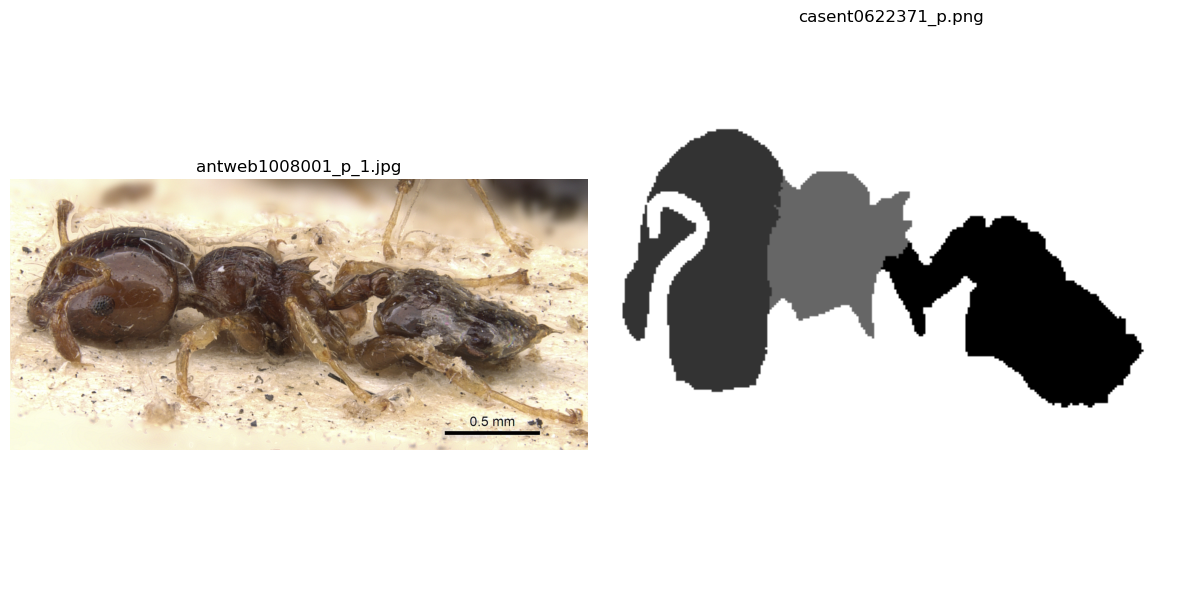

In [55]:
index = 139
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(images[index])
ax[0].axis('off') 
ax[0].set_title(image_file_names[index])

ax[1].imshow(masks_filtered[index], cmap='gray')
ax[1].axis('off') 
ax[1].set_title(mask_file_names[index])

plt.tight_layout()
plt.show()

In [34]:
def get_color_value(index):

    color_value = df[['r_thorax', 'g_thorax', 'b_thorax']].iloc[index]

    #Plotting thorax color value
    color = (color_value.iloc[0] / 255, color_value.iloc[1] / 255, color_value.iloc[2] / 255)

    # Display the color as a patch
    plt.figure(figsize=(2, 2))
    plt.imshow([[color]])
    plt.axis('off')
    plt.show()

### Downloading images with masks to give to others
Downloading both masks and images

In [59]:
# Specify the directories where you want to save the images
images_dir = 'images_folder/'
masks_dir = 'masks_folder/'

# Create the directories if they don't exist
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

# Iterate through the images and masks and save them
for index, image in enumerate(images):
    # Save the image (images_with_mask) as a file
    image_path = os.path.join(images_dir, f'image_{index}.jpg')  # or .png
    Image.fromarray(image).save(image_path)  # Assuming the images are numpy arrays

    # Save the mask (masks_filtered) as a file
    mask_path = os.path.join(masks_dir, f'mask_{index}.jpg')  # or .png
    Image.fromarray(masks_filtered[index]).save(mask_path)  # Assuming masks_filtered is a list of numpy arrays


### Starting creating ML model
Prepare the data set for training
Resize, normalize
Find a way to connect masks to images 

In [ ]:
#Function for resizing image
#PyTorch allows you to specify the interpolation method used for resizing:
resize_transform = transforms.Resize((224, 224))
resized_img = resize_transform(img)

In [ ]:
import os
from torchvision.datasets import ImageFolder

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Assuming your images are organized in folders by class
dataset = ImageFolder(
    root='path/to/image/directory',
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)
# Create a DataLoader for batch processing
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
# Now you can iterate over batches
for batch_images, batch_labels in dataloader:
    # Process your batch of resized images
    pass

In [ ]:
SPLITS = {
    'train': list(range(0, 60)), 
    'val':   list(range(61, 70)),
    'test':  list(range(71, 100))
}